# Parking with Hindsight Experience Replay

## 1. Warming up
Initial installations and imports to load the environment and the agent.

In [8]:
# Environment
import gymnasium as gym # environment manager (or use 'import gym')
import highway_env # register parking-v0
import numpy as np # numeric calculations

# Import vector and video recording utilities
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

# Agent
from stable_baselines3 import HerReplayBuffer, SAC  
# - SAC: Soft Actor-Critic  
# - HerReplayBuffer: permite replay com HER se você usar HerReplayBuffer(model.replay_buffer)

## 2. Reward Wrapper
We defined a custom wrapper to reshape the reward, penalizing distance, angle error and speed.

In [4]:
class ParkingRewardWrapper(gym.Wrapper):
    def step(self, action):
        obs, reward, done, info = super().step(action)
        # Extracts current and target position
        pos = info["position"]
        target = info["target_position"]
        # Extracts current and target position
        dist = np.linalg.norm(pos - target)
        # Angle difference
        angle_diff = abs(info["angle_error"])
        # Penalty for distance and angle
        reward -= 0.1 * dist
        reward -= 0.05 * angle_diff
        # Penalizes speed (unnecessary inertia)
        speed = np.linalg.norm(info["velocity"])
        reward -= 0.01 * speed
        return obs, reward, done, info

## 3. Training
Creation of the vectorized environment, video recording and SAC training.

In [6]:
LEARNING_STEPS = 200_000 # total number of interactions

# Create base instance of parking-v0
env = gym.make('parking-v0')

# Video frequency and duration
record_freq = 50_000 # every 50k steps
video_length = 500 # max steps per video
log_folder = "./videos" # output folder

# Vectorization: 4 identical environments in parallel
venv = DummyVecEnv([
    lambda: gym.make('parking-v0', render_mode='rgb_array')
    for _ in range(4)
])

# Automatically records video on the defined trigger
venv = VecVideoRecorder(
    venv,
    video_folder=log_folder,
    record_video_trigger=lambda step: step % record_freq == 0,
    video_length=video_length,
    name_prefix="parking_learn"
)

# Create and configure SAC agent with Dict obs compatible policy
model = SAC(
    policy="MultiInputPolicy", # policy for observations in dict
    env=env, # note: here we use the "simple" env for training
    learning_starts=10_000, # starts updating after 10k steps
    verbose=1,
    tensorboard_log="logs", # logs for TensorBoard
    buffer_size=int(1e6), # replay buffer size
    learning_rate=1e-3,
    gamma=0.99, # discount factor
    batch_size=512,
    tau=0.05, # smoothing for target network
    ent_coef="auto", # adaptive entropy coefficient
    policy_kwargs=dict(net_arch=[256, 256])
)

# Perform learning
model.learn(total_timesteps=LEARNING_STEPS)

# Save model and optionally replay buffer to HER
model.save("models/sac_parking")
model.save_replay_buffer("models/buffer.pkl")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 75.2     |
|    ep_rew_mean     | -43.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 363      |
|    time_elapsed    | 0        |
|    total_timesteps | 301      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83.2     |
|    ep_rew_mean     | -44.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 393      |
|    time_elapsed    | 1        |
|    total_timesteps | 666      |
---------------------------------


KeyboardInterrupt: 

## Visualization of an episode
Load the trained model, run an episode by recording frames and animating on the notebook.

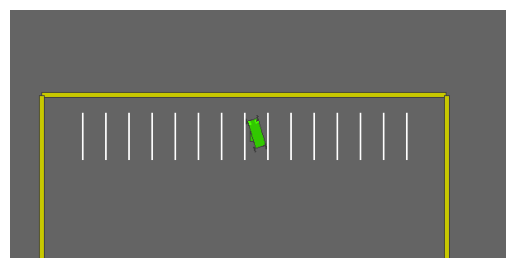

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Charge the trained SAC
model = SAC.load("models/sac_parking")

# Create environment in render mode
env = gym.make('parking-v0', render_mode='rgb_array')
obs, info = env.reset() # reset returns obs and info

frames = []
done = False

# Run the episode until it finishes
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    frames.append(env.render()) # coleta frame

env.close()

# Assemble a figure for animation
fig = plt.figure()
im = plt.imshow(frames[0])
plt.axis('off')

def update(frame_idx):
    im.set_data(frames[frame_idx])
    return [im]

# Create and display animation
anim = animation.FuncAnimation(
    fig, update,
    frames=len(frames),
    interval=50, # ms between frames
    blit=True
)
HTML(anim.to_jshtml())